<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/cyforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%writefile kaggle.json
{"username":"rammellutz","key":"bc9c85fb114c7ca4f3f046207998604c"}

Writing kaggle.json


In [3]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!kaggle datasets download -d bpwqsdd/ethusdt01012018
!unzip ethusdt01012018.zip
!mkdir input
!mv *.npy input/

In [1]:
from IPython.display import clear_output
import numpy as np
import tensorflow as tf
import copy
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [2]:
seq_len = int(24*3*60)
batch_size = 20*8
buffer_size = 20

learnrate = 0.0001
looks_in_future = 30

datadir = "input/"

valid_symbols = ['ETHUSDT', 'AAVEUSDT', 'ADAUSDT', 'ADXUSDT', 'AIONUSDT', 'AVAXUSDT', 'AXSUSDT', 'BATUSDT', 'BLZUSDT', 'BNBUSDT', 'BNTUSDT', 'CHRUSDT', 'CVCUSDT', 'DASHUSDT', 'DATAUSDT', 'DENTUSDT', 'DEXEUSDT', 'DOTUSDT', 'ELFUSDT', 'ENJUSDT', 'EOSUSDT', 'ETCUSDT', 'FIROUSDT', 'FTMUSDT', 'FUNUSDT', 'GALAUSDT', 'GHSTUSDT', 'GRTUSDT', 'GXSUSDT', 'HOTUSDT', 'ICXUSDT', 'IOSTUSDT', 'IOTAUSDT', 'IOTXUSDT', 'KEYUSDT', 'KMDUSDT', 'KNCUSDT', 'LINKUSDT', 'LRCUSDT', 'LSKUSDT', 'LTCUSDT', 'MANAUSDT', 'MATICUSDT', 'MFTUSDT', 'MTLUSDT', 'NANOUSDT', 'NEOUSDT', 'OMGUSDT', 'ONTUSDT', 'POWRUSDT', 'PUNDIXUSDT', 'REPUSDT', 'RLCUSDT', 'SANDUSDT', 'SCUSDT', 'SOLUSDT', 'STRAXUSDT', 'THETAUSDT', 'TRXUSDT', 'VETUSDT', 'VGXUSDT', 'WANUSDT', 'WAVESUSDT', 'XEMUSDT', 'XLMUSDT', 'XMRUSDT', 'XRPUSDT', 'XVGUSDT', 'ZECUSDT', 'ZENUSDT', 'ZILUSDT', 'ZRXUSDT']

print(len(valid_symbols),"symbols found")
symbol = valid_symbols[0]
print("woking on", symbol)

72 symbols found
woking on ETHUSDT


In [8]:
npd = np.load(datadir+symbol+".npy",allow_pickle=True)
print("loaded:", npd.shape)

loaded: (2077934, 7)


  0%|          | 0/2077933 [00:00<?, ?it/s]

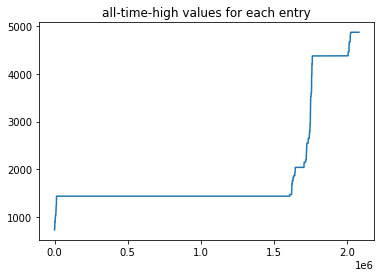

In [9]:
#for each entry we are calculating the maximum price this crypto reached until than
all_time_high = []
last_max_val = 0
for i in tqdm(range(1,npd.shape[0])):
    current_val = float(npd[i][3])
    if(current_val > last_max_val):
        last_max_val = current_val
    
    all_time_high.append(last_max_val)

print("")
plt.title("all-time-high values for each entry")
plt.plot(all_time_high)
plt.show()

In [10]:
npd_relative = []
print("converting to relative data...")

prices_relative_to_ath_max = []
prices_relative_to_ath_min = []

relative_price_changes_max = []
relative_price_changes_min = []

for i in tqdm(range(npd.shape[0]-1)):
    #changes
    price_open  = (float(npd[i+1][2])-float(npd[i][2]))/float(npd[i][2])*10
    price_high  = (float(npd[i+1][3])-float(npd[i][3]))/float(npd[i][3])*10
    price_low   = (float(npd[i+1][4])-float(npd[i][4]))/float(npd[i][4])*10
    price_close = (float(npd[i+1][5])-float(npd[i][5]))/float(npd[i][5])*10
    volume = 0
    if float(npd[i][6]) > 0:
        volume = (float(npd[i+1][6])-float(npd[i][6]))/float(npd[i][6])
        
    #max/min price in price / ath
    price_relative_ath_max = float(npd[i+1][3]) / all_time_high[i]
    price_relative_ath_min = float(npd[i+1][4]) / all_time_high[i]
    
    prices_relative_to_ath_max.append(price_relative_ath_max)
    prices_relative_to_ath_min.append(price_relative_ath_min)
    relative_price_changes_min.append(price_high)
    relative_price_changes_max.append(price_low)
    
    npd_relative.append((price_open, price_high, price_low, price_close, volume, price_relative_ath_max, price_relative_ath_min))
    
npd = np.array(npd_relative,dtype="float32")

converting to relative data...


  0%|          | 0/2077933 [00:00<?, ?it/s]

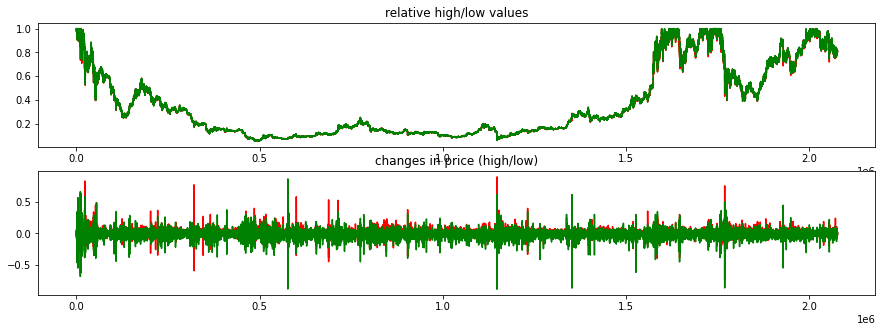

In [11]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,5))
ax1.set_title("relative high/low values")
ax1.plot(prices_relative_to_ath_min, color="red")
ax1.plot(prices_relative_to_ath_max, color="green")

ax2.set_title("changes in price (high/low)")
ax2.plot(relative_price_changes_min, color="red")
ax2.plot(relative_price_changes_max, color="green")

fig.show()

In [19]:
def unpack_batch(batch):
    X=[]
    Y=[]
    for i in batch:
            X.append(i[0])
            Y.append(i[1])
    X = np.array(X,dtype="float32")
    Y = np.array(Y,dtype="float32")
    
    return (X, Y)
          
def array_to_samples(ar):
    samples = []
    l = ar.shape[0]-seq_len-looks_in_future
    
    for i in range(l):
        array_future_data = ar[i+seq_len+1:i+seq_len+1+looks_in_future]
        maxval = np.amax(array_future_data, axis=0)[5]
        minval = np.amin(array_future_data, axis=0)[6]
        
        maxval_relative = (maxval - ar[i+seq_len][5]) /ar[i+seq_len][5]*10
        minval_relative = (minval - ar[i+seq_len][6]) /ar[i+seq_len][6]*10
        
        data = (ar[i:i+seq_len],(maxval_relative,minval_relative))
        samples.append(np.array(data,dtype=object))
    
    return np.array(samples,dtype=object)

In [20]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.54.127.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.54.127.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [21]:
with strategy.scope():
  l_in = tf.keras.layers.Input(shape=(seq_len,7), batch_size=batch_size)
  c1 = tf.keras.layers.Conv1D(64,16,activation="relu")(l_in)
  c2 = tf.keras.layers.Conv1D(128,8,activation="relu")(c1)
  c3 = tf.keras.layers.Conv1D(256,4,activation="relu")(c2)
  rn1 = tf.keras.layers.GRU(128, return_sequences=True)(c3)
  rn2 = tf.keras.layers.GRU(128, return_sequences=True)(rn1)
  rn3 = tf.keras.layers.GRU(128, return_sequences=False)(rn2)
  flat = tf.keras.layers.Flatten()(rn3)
  d1 = tf.keras.layers.Dense(256,activation="relu")(flat)
  d2 = tf.keras.layers.Dense(128,activation="relu")(d1)
  d3 = tf.keras.layers.Dense(64,activation="relu")(d2)
  l_out = tf.keras.layers.Dense(2)(d3)

  model = tf.keras.Model(l_in, l_out)


  training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)

#model.summary()

In [22]:
@tf.function
def train(X,Y):
  with tf.GradientTape() as tape:
        outputs = model(X)
        loss = tf.nn.compute_average_loss(tf.keras.losses.mse(Y,outputs), global_batch_size=batch_size)
    
  gradients = tape.gradient(loss,model.trainable_variables)
  opt.apply_gradients(zip(gradients,model.trainable_variables))
  training_loss.update_state(loss * strategy.num_replicas_in_sync)


In [23]:
samples_len = npd.shape[0] - seq_len - looks_in_future
batch_num = int(samples_len / batch_size)
print("number of batches:",batch_num)
print("number of samples:",samples_len)

run_nums = int(batch_num / buffer_size)
last_batches = int(batch_num % buffer_size)
print(run_nums, "total buffers with",last_batches,"batches in last buffer")

opt = tf.keras.optimizers.Adam(learnrate)

number of batches: 12959
number of samples: 2073583
647 total buffers with 19 batches in last buffer


 7 / 647 : 14.032057523727417s   (8980.516815185547s left)

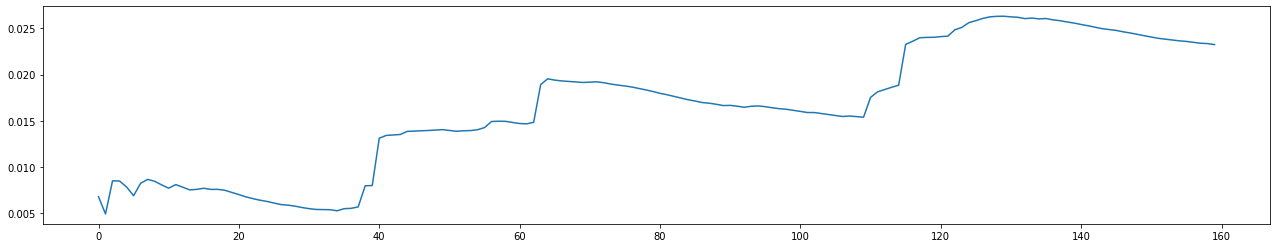

calculating new buffer...
converting to dataset...


In [ ]:
losses = []
t0 = time.time()
for s in range(run_nums):

    print("calculating new buffer...")
    if(s < run_nums - 1):
      buffer_len = buffer_size * batch_size + seq_len + looks_in_future
    else:
      buffer_len = last_batches * batch_size + seq_len + looks_in_future

    buffer_start = s * buffer_size * batch_size
    buffer_end =  s * buffer_size * batch_size + buffer_len

    curr_batch = npd[buffer_start:buffer_end]
    samples = array_to_samples(curr_batch)
    X, Y = unpack_batch(samples)
    
    print("converting to dataset...")
    X_dataset = tf.data.Dataset.from_tensor_slices((X)).batch(batch_size)
    X_dataset = strategy.experimental_distribute_dataset(X_dataset)

    Y_dataset = tf.data.Dataset.from_tensor_slices((Y)).batch(batch_size) 
    Y_dataset = strategy.experimental_distribute_dataset(Y_dataset)

    print("start training...")
    for (X_batch,Y_batch) in zip(X_dataset,Y_dataset):
      strategy.run(train,args=(X_batch,Y_batch))
      losses.append(training_loss.result().numpy())
    
    clear_output()
    t1 = time.time()
    past = t1-t0
    t0 = t1
    print("\r",s,"/",run_nums, ":", str(past)+"s   ("+str((run_nums-s)*past)+"s left)", end="")

    plt.figure(figsize=(22,4))
    plt.plot(losses)
    plt.show()


clear_output()

In [ ]:
plt.figure(figsize=(22,4))
plt.plot(losses)
plt.show()

model.save_weights("/content/drive/MyDrive/weights/"+symbol+".h5", overwrite=True)
np.save("/content/drive/MyDrive/losses/"+symbol,np.array(losses))
